# Agrupamiento de lenguajes a partir de redes de co-ocurrencia de textos traducidos: *Pedro Páramo*

Este proyecto reproduce el análisis de [Liu y Cong (2013)](https://link.springer.com/article/10.1007/s11434-013-5711-8)


## Hipótesis

Las topologías de las redes de co-ocurrencia de palabras reflejan las relaciones de parentesco entre los lenguajes.

## Predicción

La topología de las redes de co-ocurrencia de un mismo texto traducido en diferentes lenguajes, serán más similares entre sí si los lenguajes pertenecen a una misma familia lingüística. 


## Método

### 1. Definición de las redes

Se definieron un total de 10 redes de co-ocurrencia de palabras a partir de traducciones la obras *Pedro Páramo* de Juan Rulfo. En estas redes no dirigidas cada vértice ($v_i$) representan una palabra distinta y existe un enlcace ($e_i$) entre la palabra $v_n$ y $v_m$ si $v_n$ es vecina a $v_m$. Por ejemplo, para las oraciones "El perro está enojado con el gato. El niño está llorando.", se obtienen el siguiente conjunto de vérices ($V$) y de enlaces ($E$):

$V$ = *{el,perro,está,enojado,con,gato,.,niño,llorando}*

$E$ = *{{el,perro},{perro,está},{está,enojado},{enojado,con},{con, el}, {el,gato},{gato,.},{.,el},{el,niño},{niño,llorando},{llorando,.}}*


In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import pandas as pd
import os


Texto original:
Vine a Comala porque me dijeron que acá vivía mi padre, un tal

Texto procesado (enlaces de la red):
['vine', 'a']
['a', 'comala']
['comala', 'porque']
['porque', 'me']
['me', 'dijeron']
['dijeron', 'que']
['que', 'acá']
['acá', 'vivía']
['vivía', 'mi']
['mi', 'padre']


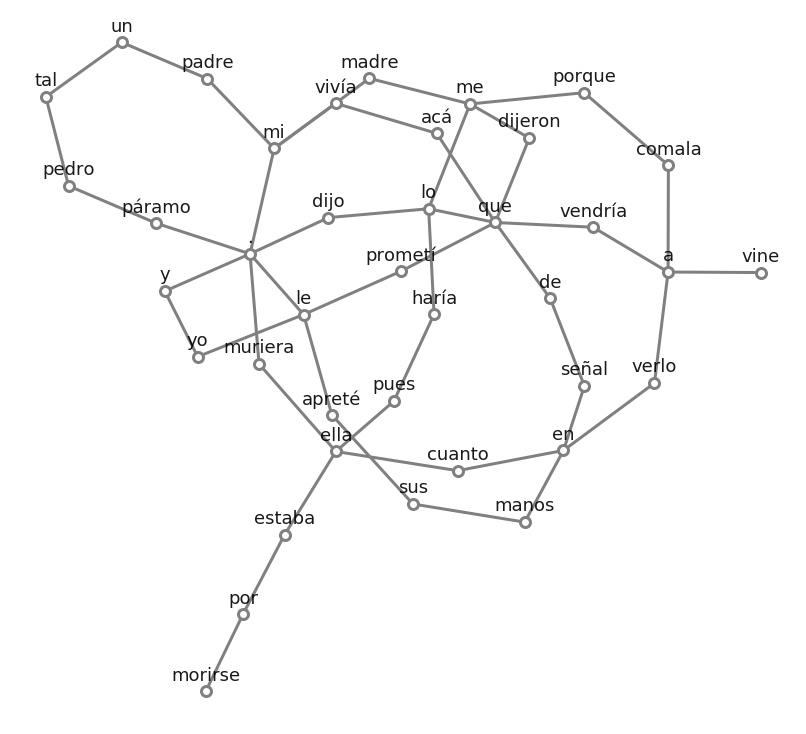

In [5]:
## se leen los archivos
obra = 'pedroparamo'
textos = {}

for nombre_archivo in os.listdir('textos/' + obra):
    if(nombre_archivo[-4:] == '.txt'):
        with open('textos/' + obra + '/' + nombre_archivo) as archivo:
            idioma = nombre_archivo.split('-')[1].split('.')[0]
            textos[idioma] = archivo.read()

print('\nTexto original:')
print(textos['espanol'][:62])

## se limpian los textos
def limpiarTexto (text):
    text = text.lower()
    skips = ['...','…','’',',','„',';',':','"','“',"'",'¡','!','¿','?','\n','-','–','—','”','»','«','(',')','‘','\t\u3000\u3000','›','‹','1','2','3','4','5','6','7','8','9','0','^','ᵉ','\\ ','[','*',']','\x0c','..','’’','°']
    for skip in skips:
        text = text.replace(skip, ' ')
        text = re.sub(' +', ' ', text)
    return text

for idioma, texto in textos.items():
    textos[idioma] = limpiarTexto(texto)

## se definen los enlaces de las redes
def crearEnlaces( texto ):
    texto_lista = re.findall(r"[\w']+|[.,!?;]", texto) 
    pares_palabras = []
    for i in range( len(texto_lista) - 1):
        par = [ texto_lista[i], texto_lista[i + 1]]
        pares_palabras.append(par)
    return pares_palabras

for idioma, texto in textos.items():
    textos[idioma] = crearEnlaces(texto)

print('\nTexto procesado (enlaces de la red):')
for enlace in textos['espanol'][:10]:
    print(enlace)
    
## se grafica un ejemplo reducido de la red construida
numero_de_nodos = 50
GReducidaEjemplo = nx.Graph(textos['espanol'][:numero_de_nodos - 1])

figura = plt.figure(figsize=(11,10))
  
pos = nx.kamada_kawai_layout(GReducidaEjemplo)

nx.draw(GReducidaEjemplo,
        pos,
        node_color='w',
        edgecolors = 'grey',
        linewidths=3,
        node_size=100,
        node_shape='o',
        width=3,
        edge_color='grey')

m = 0.04
for key, value in pos.items():
    pos[key] = np.array( [(pos[key][0]), (pos[key][1]+m)] ) 
    
labels = nx.draw_networkx_labels(GReducidaEjemplo,
                                 pos,
                                 font_size = 18,
                                 alpha=0.9,) 


### 2. Análisis cuantitativo de las redes

Se calcularon las siguentes medidas para cada red:
1. número de nodos ($V$)
1. número de enlaces ($E$)
1. grado promedio (k_prom=$<k>$)
1. longitud promedio (long_prom=$L$)
1. coeficiente de clustering (clus=$C$)
1. diámetro (diam=$D$)
1. centralización de red (centralizacion=$NC$)
1. heterogeneidad de red (hetereogenedidad=$NH$)
1. exponente de mejor ajuste de la ley de potencia a la distribución de grado (ajuste_dist_grado=$\alpha_1$)
1. $R^2$ del ajuste a la ley de potencias a la distrubución de grado (ajuste_dist_grado_R_sqrt=$R^2_1$)
1. exponente de mejor ajuste de la ley de potencias a la distribución de grado de los vecinos cercanos (ajuste_dist_nadc=$\alpha_2$)
1. $R^2$ del mejor ajuste de la ley de potencias a la distribución de grado de los vecinos cercanos (ajuste_dist_nadc_R_sqrt=$R^2_2$)


In [6]:
## ESTA CELDA SE TARDA MUCHO EN CORRER
# se contruyen las redes
Gs = {}

for idioma, enlaces in textos.items():
    Gs[idioma] = nx.Graph(enlaces) 

# se calculan las medidas
idiomas = []
V = []
E = []
k_prom = []
long_prom = []
clus = []
diam = []
centralizacion = []
heterogeneidad = []
ajuste_dist_grado_R_sqrt = []
ajuste_dist_grado =  []
ajuste_dist_nadc_R_sqrt = []
ajuste_dist_nadc = []

from scipy import stats

j=2

for idioma, red in Gs.items():
    idiomas.append(idioma)
    V.append( len(red.nodes()) )
    E.append( len(red.edges()) )
    k_prom.append( j * len( red.edges() ) / len( red.nodes() ) )
    long_prom.append( nx.average_shortest_path_length(red) )
    clus.append( nx.average_clustering( red ) )
    diam.append( nx.diameter( red ) )
    centralizacion.append( ( max( np.array( list( dict( red.degree ).values() ) ) ) / len( red.nodes ) ) - ( ( j * len( red.edges() ) / len( red.nodes() ) ) / ( len( red.nodes() ) - 1 ) ) )
    heterogeneidad.append( ( np.var( np.array( list( dict( red.degree ).values() ) ) ) )**(1/2) / ( j * len( red.edges() ) / len( red.nodes() ) )  )
    
    # calculo alfa_1 y R^2_1
    grados = np.array( list(dict( red.degree ).values() ) )
    x, y = np.unique(grados, return_counts = True)
    y = np.log10(y)
    x = np.log10(x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ajuste_dist_grado.append( -slope )
    ajuste_dist_grado_R_sqrt.append( r_value**2 )
    
    # calculo alfa_2 y R^2_2
    x = list( nx.average_degree_connectivity( red ).keys() )
    y = list( nx.average_degree_connectivity( red ).values() )
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))
    ajuste_dist_nadc.append( -slope )
    ajuste_dist_nadc_R_sqrt.append( r_value**2 )
    

In [9]:
#df = pd.read_csv('medidas-pedroparamo.csv').iloc[:,1:] # importar los datos de corridas previas de este notebook para no tener que esperar a que corra el de arriva

nombres_columnas = ['idioma','$V$','$E$','$<k>$','$L$','$C$','$D$','$NC$','$NH$',r'$\alpha_1$','$R^2_1$',r'$\alpha_2$','$R^2_2$']
df = pd.DataFrame( zip(idiomas,V,E,k_prom,long_prom,clus,diam,centralizacion,heterogeneidad,ajuste_dist_grado,ajuste_dist_grado_R_sqrt,ajuste_dist_nadc,ajuste_dist_nadc_R_sqrt), 
                  columns = nombres_columnas )

df.to_csv('medidas-perdoparamo.csv')

df

,idioma,$V$,$E$,$<k>$,$L$,$C$,$D$,$NC$,$NH$,$\alpha_1$,$R^2_1$,$\alpha_2$,$R^2_2$
0,frances,4868,21167,8.696385,2.805128,0.471232,6,0.324425,4.726561,1.016595,0.705745,0.538929,0.904039
1,italiano,5190,20891,8.050482,2.853533,0.381577,6,0.360684,5.085643,1.061046,0.722912,0.589130,0.846310
2,aleman,5099,21589,8.467935,2.892434,0.385295,6,0.336641,4.543143,1.073287,0.728582,0.442553,0.907709
3,espanol,5214,20195,7.746452,2.783024,0.456350,6,0.366370,5.619480,1.028593,0.700513,0.610269,0.930558
4,turco,7476,18637,4.985821,3.332490,0.161919,10,0.346711,6.588286,1.275944,0.749160,0.611340,0.954940
5,euskera,7144,22807,6.384938,3.221799,0.192491,8,0.333653,5.419360,1.234160,0.741169,0.530044,0.943216
6,portugues,4936,20511,8.310778,2.802475,0.445556,6,0.369061,5.136978,1.072964,0.716362,0.573958,0.913937
7,ruso,9066,26111,5.760203,3.155216,0.279447,9,0.313285,6.808792,1.094374,0.693722,0.549264,0.958736
8,ingles,3268,17897,10.952876,2.691579,0.498421,6,0.363232,3.885885,1.039906,0.746479,0.488111,0.924605
9,chino,6304,7179,2.277602,12.042783,0.005268,57,0.014867,1.159112,1.221211,0.504971,0.233940,0.243540


### 3. Visualización de la distribución de grado de las redes

Se graficó la distribución de grado de las redes en...
- escala lineal
- escala logaritmica (bin lineal)
- escala logaritmica (bin logarítmico)
- escala logaritmica (bin logarítmico) y mejor ajuste a la ley de potencias
- distriución acumulada

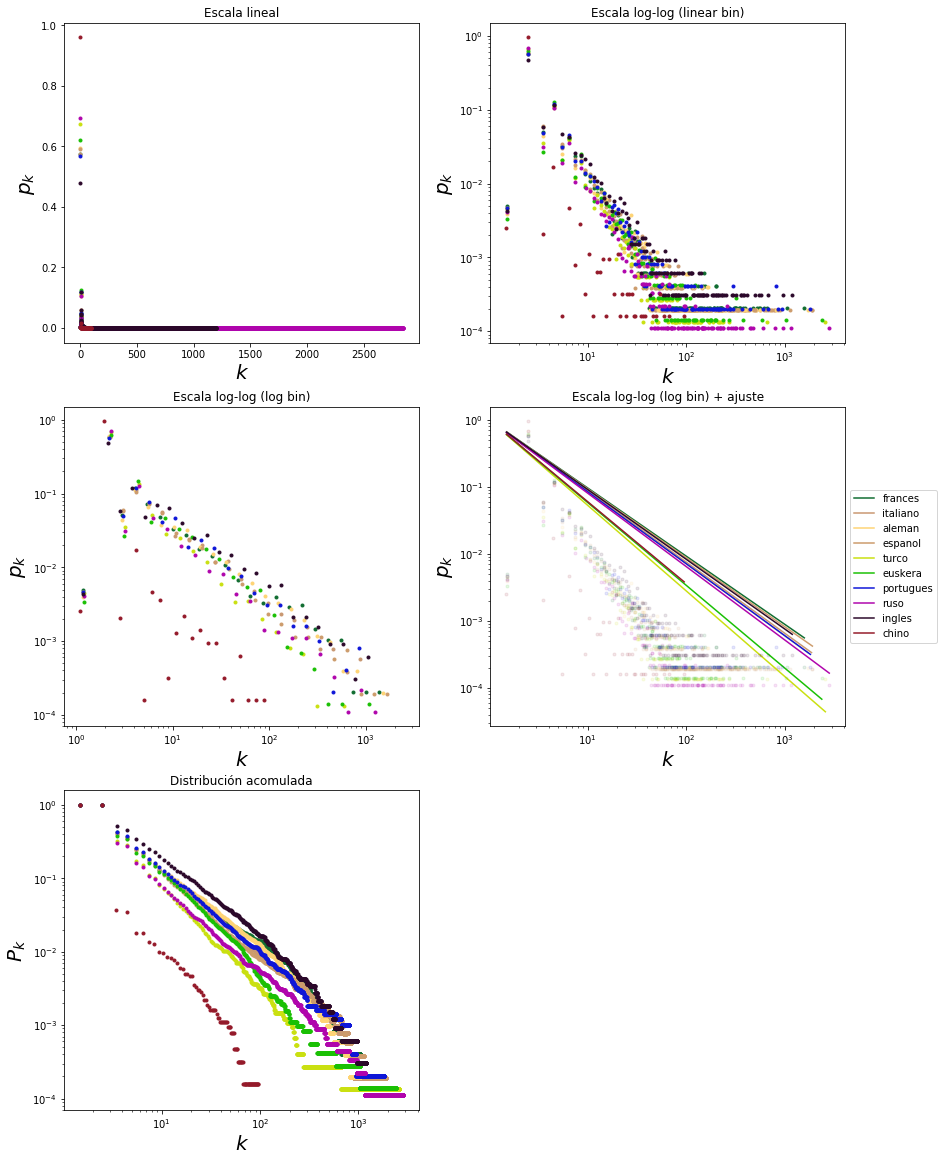

In [10]:
# se definen las funciones para graficar
def graficarEscalaLineal(G, lab, col, sizefont):
    grados = np.array( list(dict( G.degree ).values()))
    y,x = np.histogram(grados , bins = max(grados))
    x_med = 0.5*(x[:-1] + x [1:])
    plt.plot(x_med, (y/len( G.nodes())), '.', color= col, label = lab)
    plt.xlabel('$k$', fontsize= sizefont)
    plt.ylabel('$p_{k}$', fontsize= sizefont)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def graficarBinLinear(G, lab, col, sizefont):
    grados = np.array( list(dict( G.degree ).values()))
    y,x = np.histogram(grados, bins = max(grados) )
    x_med = 0.5*(x[:-1] + x [1:])
    plt.plot(x_med, (y/len( G.nodes())), '.', color= col, label = lab)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$k$', fontsize= sizefont)
    plt.ylabel('$p_{k}$', fontsize= sizefont)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
def graficarBinLog(G, lab, col, sizefont):
    grados = np.array( list(dict( G.degree ).values()))
    log_bin = np.logspace(0, np.log10(max(grados)), 25)
    y,x = np.histogram(grados, bins = log_bin )
    x_med = 0.5*(x[:-1] + x [1:])
    plt.plot(x_med, (y/len( G.nodes())), '.', color= col, label = lab)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$k$', fontsize= sizefont)
    plt.ylabel('$p_{k}$', fontsize= sizefont)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def graficarAcum(G, lab, col, sizefont):
    grados = np.array( list(dict( G.degree ).values()))
    y,x = np.histogram(grados, bins = max(grados) )
    y_cum = np.flip( np.cumsum( np.flip( y ) ) )
    x_med = 0.5*(x[:-1] + x [1:])
    plt.plot(x_med, (y_cum/len( G.nodes())), '.', color= col, label = lab)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$k$', fontsize= sizefont)
    plt.ylabel('$P_{k}$', fontsize= sizefont)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def graficarBinLogYAjuste(G, lab, alfa, col, sizefont):
    grados = np.array( list(dict( G.degree ).values()))
    log_bin = np.logspace(0, np.log10(max(grados)), 25)
    y,x = np.histogram(grados, bins = max(grados) )
    x_med = 0.5*(x[:-1] + x [1:])
    plt.plot(x_med, (y/len( G.nodes())), '.', color= col, alpha=0.1)
    plt.plot(x_med, 1*x_med**(-alfa), color= col, label = lab)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$k$', fontsize= sizefont)
    plt.ylabel('$p_{k}$', fontsize= sizefont)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#################################    

## configuración de gráficas
sizefont = 20
alfas = dict(zip(df['idioma'].tolist(),df[r'$\alpha_1$'].tolist()))

from random import randint
colors = []
for i in range(len(Gs)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

##################    
### se grafica ###
plt.figure(figsize = (14,20))
plt.subplot(321)

color_index = 0
for key in Gs:
    graficarEscalaLineal(Gs.get(key), key, colors[color_index], sizefont)
    color_index += 1
plt.title('Escala lineal')

color_index = 0
plt.subplot(322)
for key in Gs:
    graficarBinLinear(Gs.get(key), key, colors[color_index], sizefont)
    color_index += 1
plt.title('Escala log-log (linear bin)')

color_index = 0
plt.subplot(323)
for key in Gs:
    graficarBinLog(Gs.get(key), key, colors[color_index], sizefont)
    color_index += 1
plt.title('Escala log-log (log bin)')

color_index = 0
plt.subplot(324)
for key in Gs:
    graficarBinLogYAjuste(Gs.get(key), key, alfas[key], colors[color_index], sizefont)
    color_index += 1
plt.title('Escala log-log (log bin) + ajuste')
  
color_index = 0
plt.subplot(325)
for key in Gs:
    graficarAcum(Gs.get(key), key, colors[color_index], sizefont)
    color_index += 1
plt.title('Distribución acomulada')

plt.show()

### 4. Análisis de agrupación de las redes
Se normalizaron los datos y se aplicó un análisis de agrupamiento jerárquico a las medidas de la topología de red. Para ello se utilizó el método de Ward (este método busca la forma de reducir la varianza entre los datos y así agrupa a los que quedan más cercanos) (para los detalles del análisis ver [Liu y Cong (2013)](https://link.springer.com/article/10.1007/s11434-013-5711-8).

Los textos se clasificaron de acuerdo a distintos niveles de la clasificación de languajes en [Ethnologue](https://www.ethnologue.com/browse/families).

In [11]:
## se normalizan los datos
from sklearn import preprocessing

x = df.iloc[:,1:].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalizado = pd.DataFrame(x_scaled, columns = nombres_columnas[1:])
df_normalizado.insert( 0, 'idioma', df.idioma )

df_normalizado

,idioma,$V$,$E$,$<k>$,$L$,$C$,$D$,$NC$,$NH$,$\alpha_1$,$R^2_1$,$\alpha_2$,$R^2_2$
0,frances,0.275957,0.738855,0.739894,0.012143,0.944868,0.000000,0.873978,0.631443,0.000000,0.822209,0.808131,0.923521
1,italiano,0.331494,0.724276,0.665441,0.017319,0.763068,0.000000,0.976347,0.695001,0.171396,0.892512,0.941150,0.842803
2,aleman,0.315799,0.761145,0.713560,0.021479,0.770607,0.000000,0.908466,0.598978,0.218593,0.915730,0.552763,0.928652
3,espanol,0.335633,0.687513,0.630395,0.009779,0.914690,0.000000,0.992400,0.789490,0.046261,0.800784,0.997162,0.960601
4,turco,0.725768,0.605219,0.312177,0.068538,0.317653,0.078431,0.936898,0.960970,1.000000,1.000000,1.000000,0.994691
5,euskera,0.668506,0.825481,0.473453,0.056701,0.379647,0.039216,0.900030,0.754069,0.838890,0.967277,0.784587,0.978299
6,portugues,0.287685,0.704205,0.695445,0.011859,0.892803,0.000000,1.000000,0.704087,0.217349,0.865688,0.900946,0.937360
7,ruso,1.000000,1.000000,0.401440,0.049580,0.555973,0.058824,0.842525,1.000000,0.299901,0.772973,0.835517,1.000000
8,ingles,0.000000,0.566131,1.000000,0.000000,1.000000,0.000000,0.983543,0.482642,0.089885,0.989020,0.673477,0.952277
9,chino,0.523629,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.788962,0.000000,0.000000,0.000000


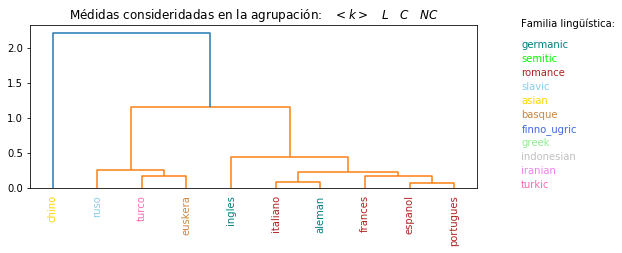

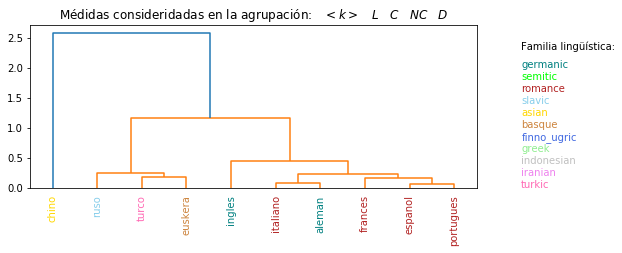

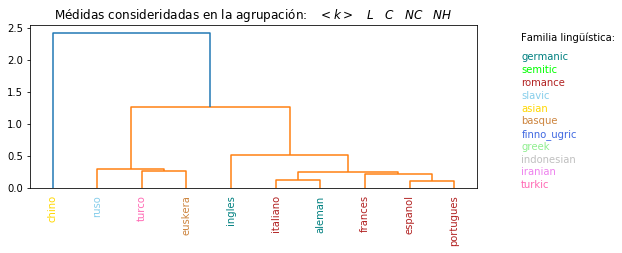

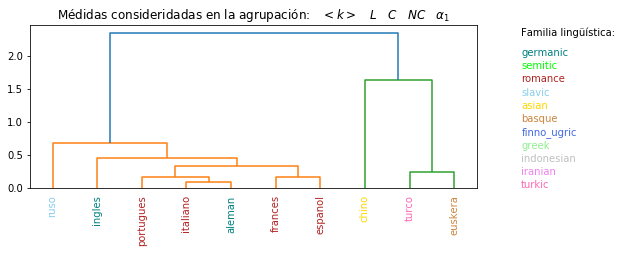

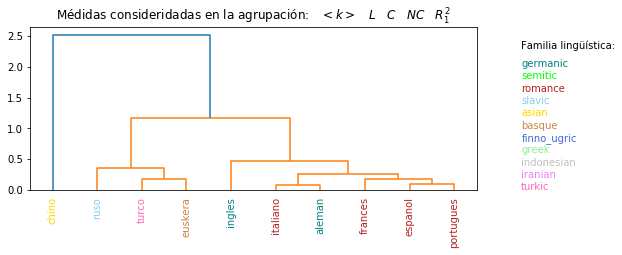

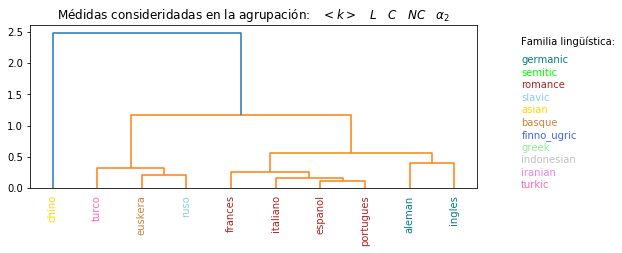

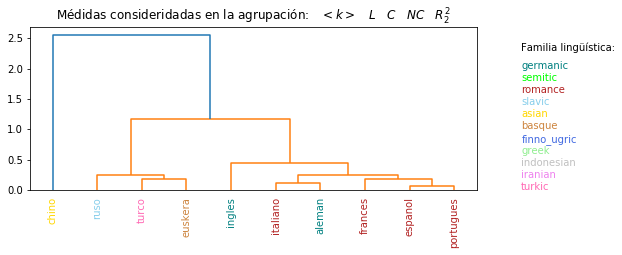

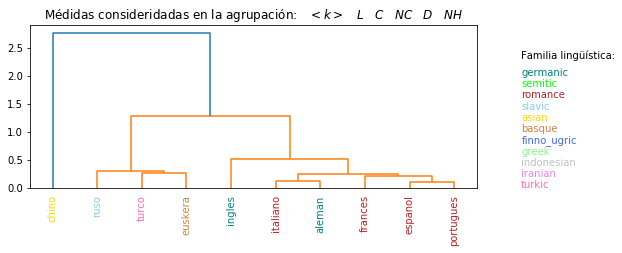

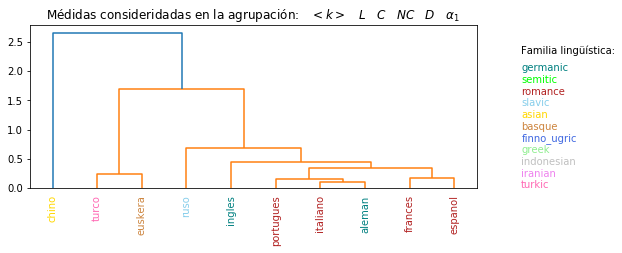

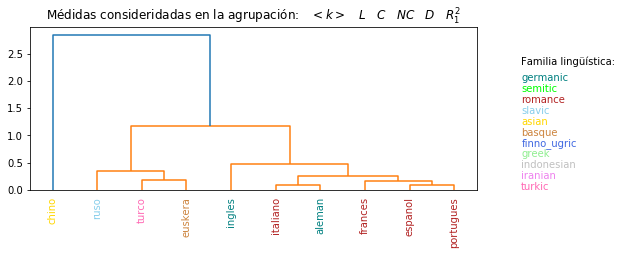

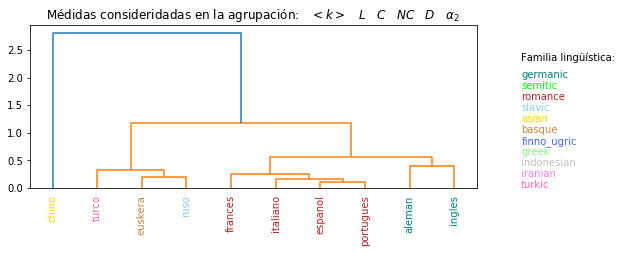

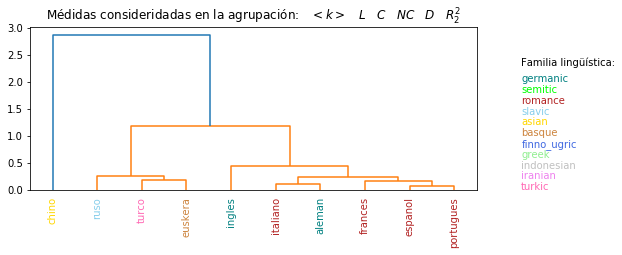

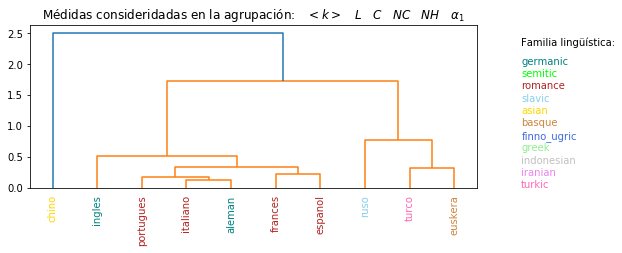

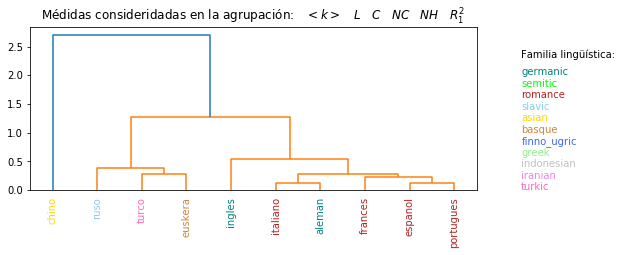

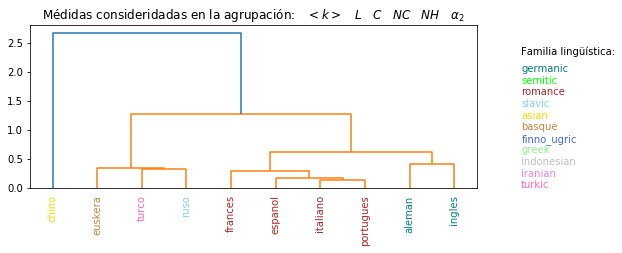

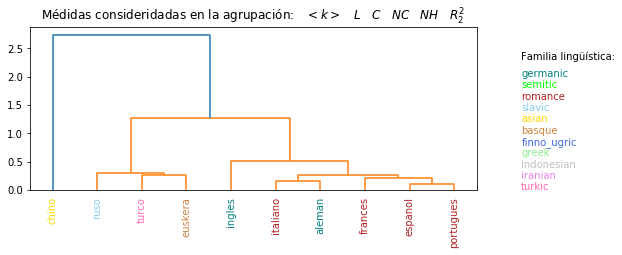

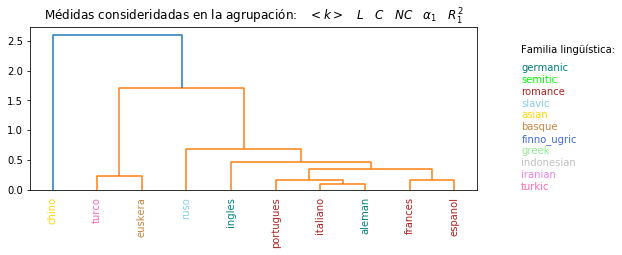

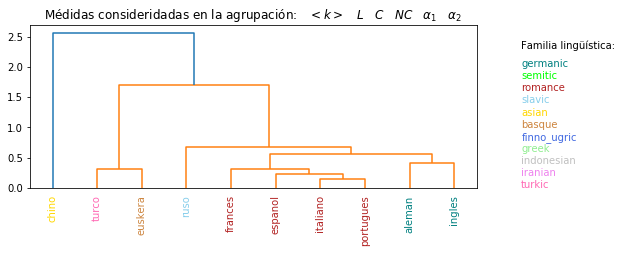

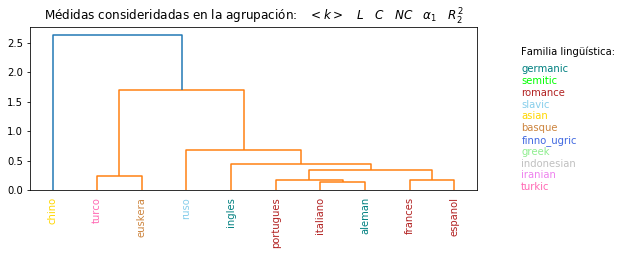

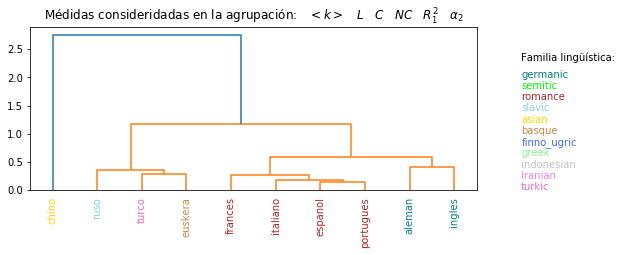

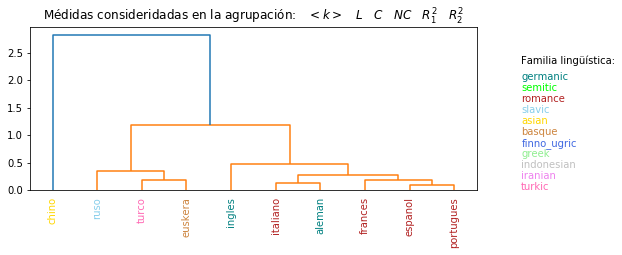

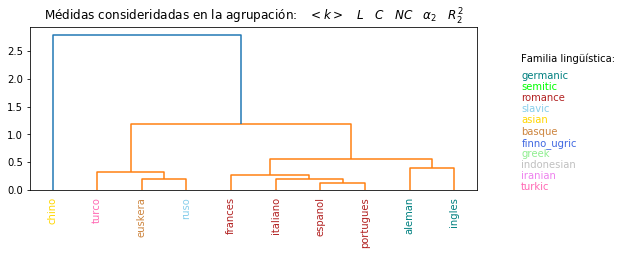

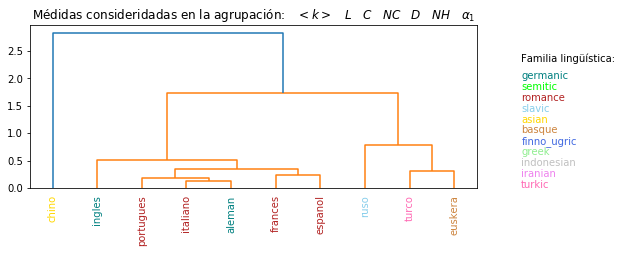

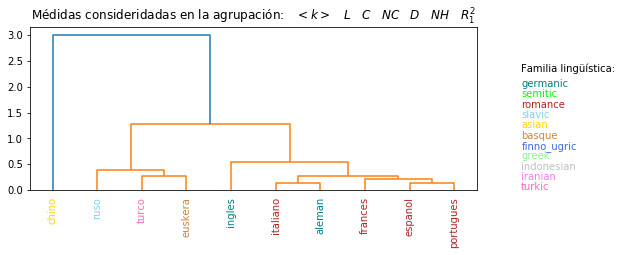

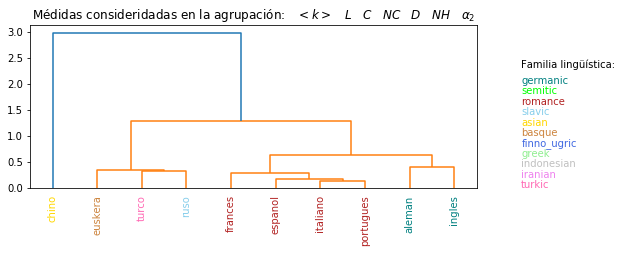

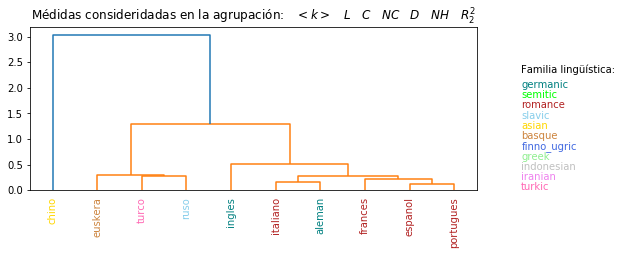

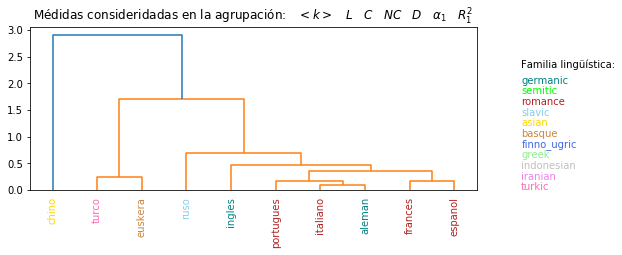

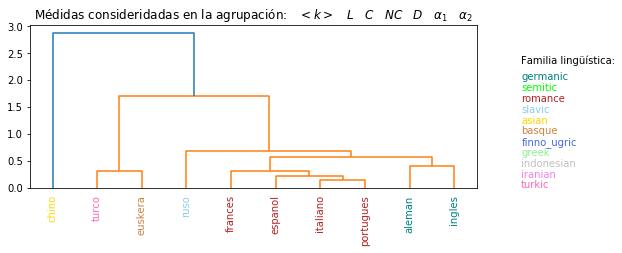

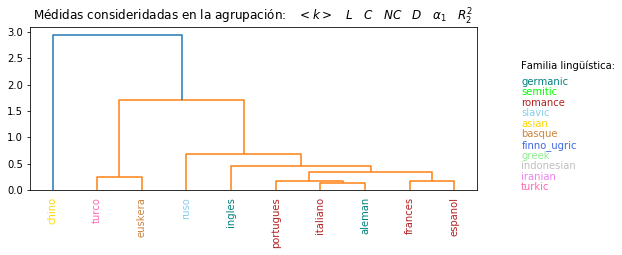

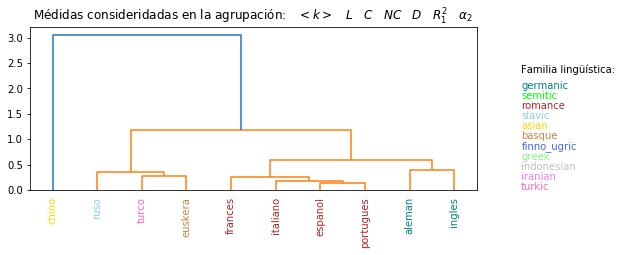

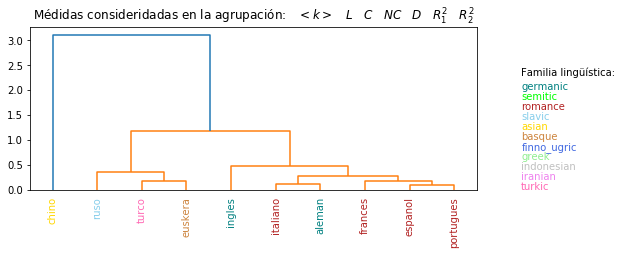

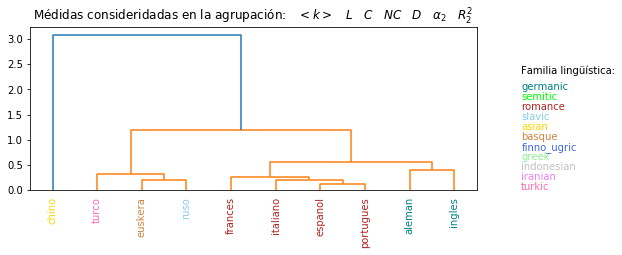

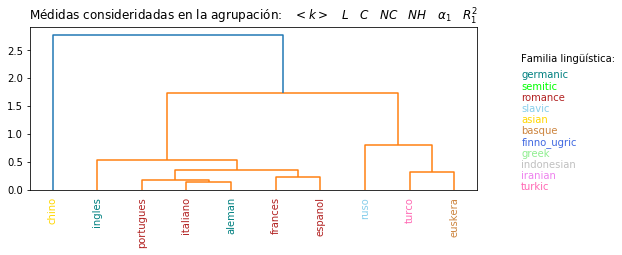

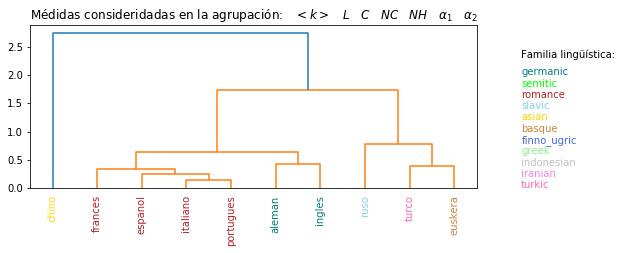

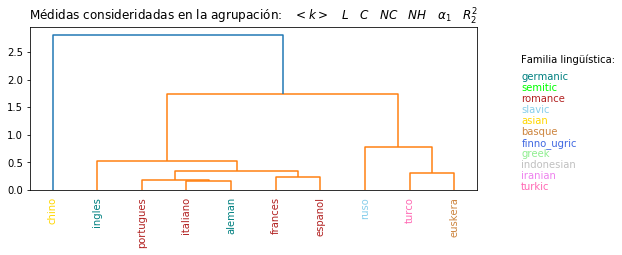

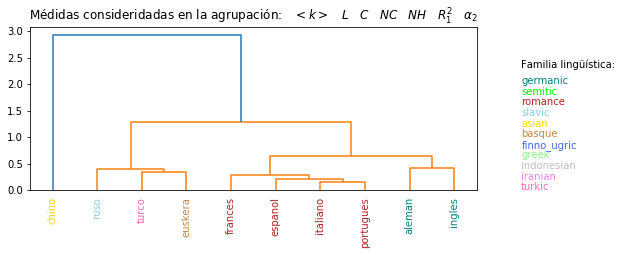

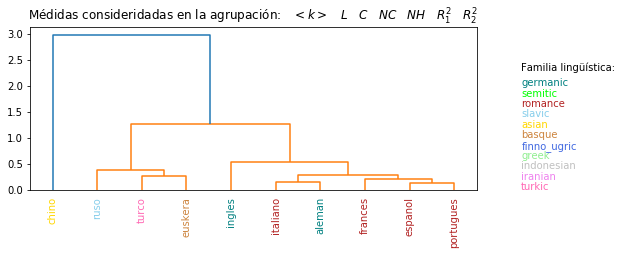

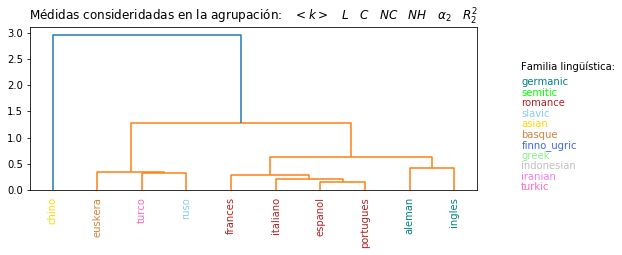

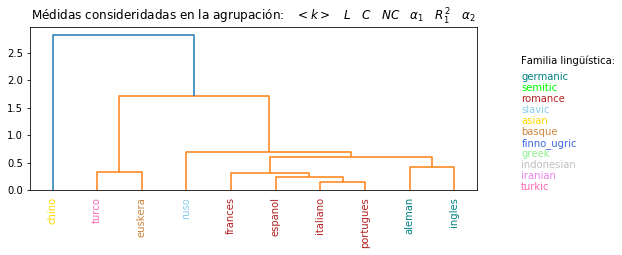

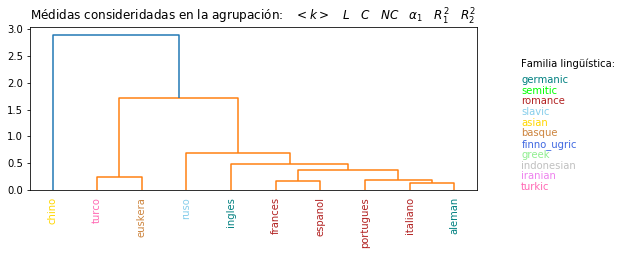

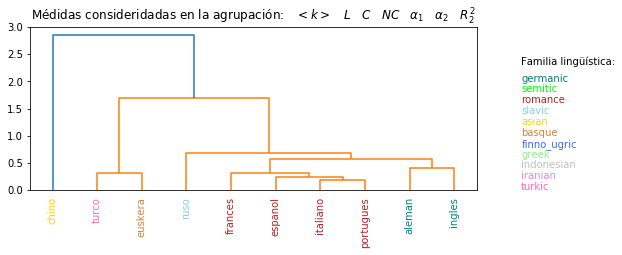

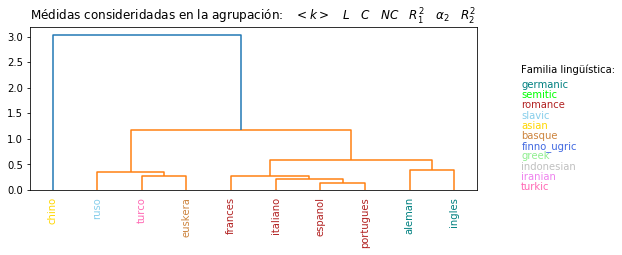

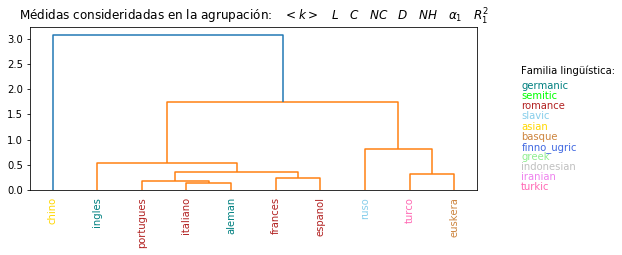

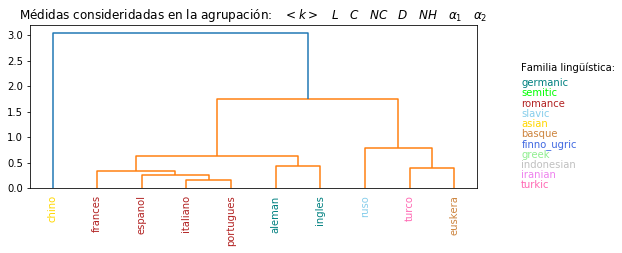

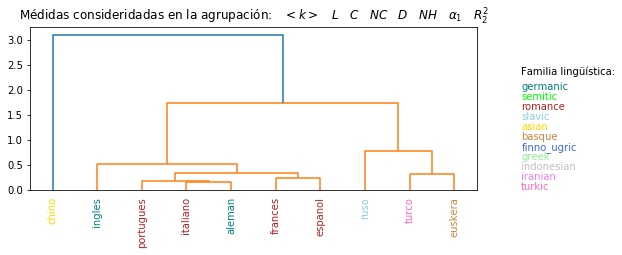

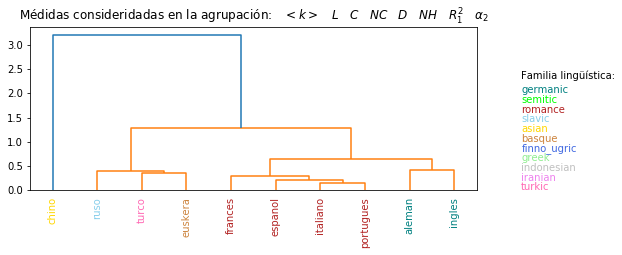

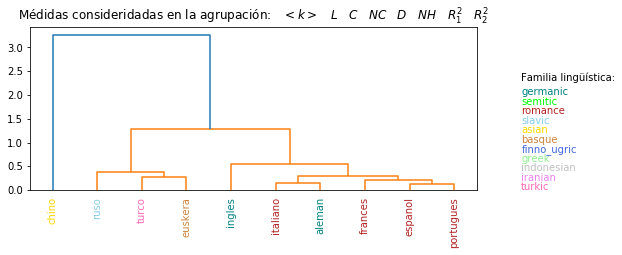

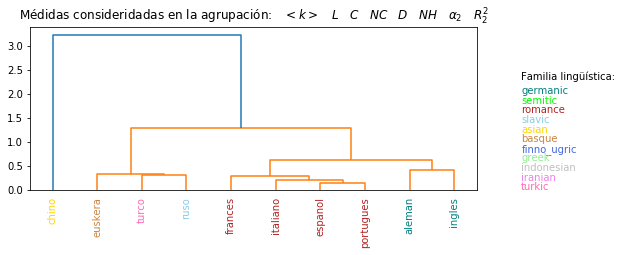

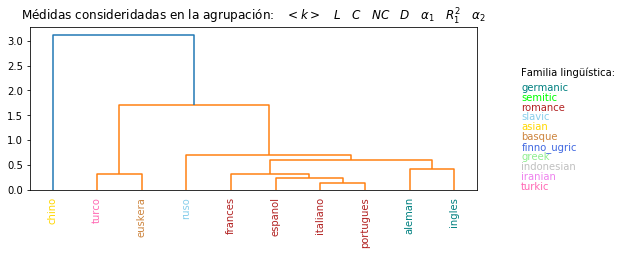

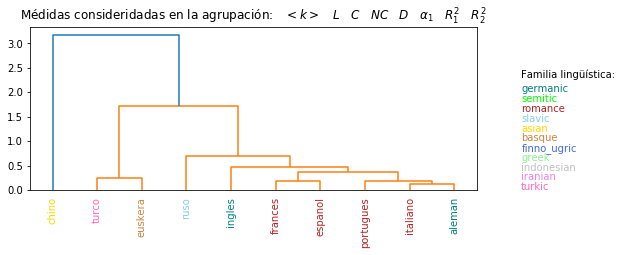

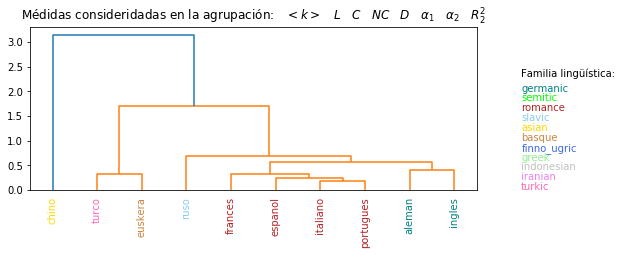

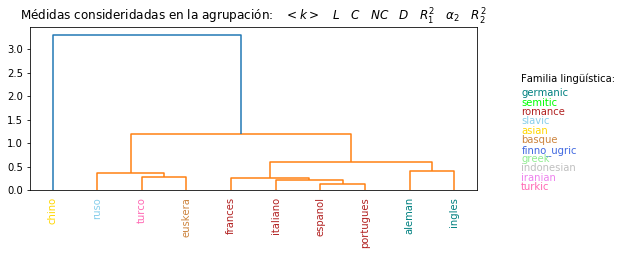

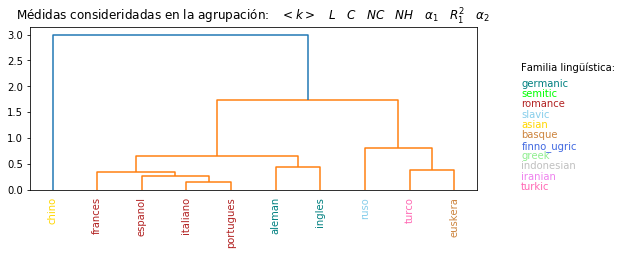

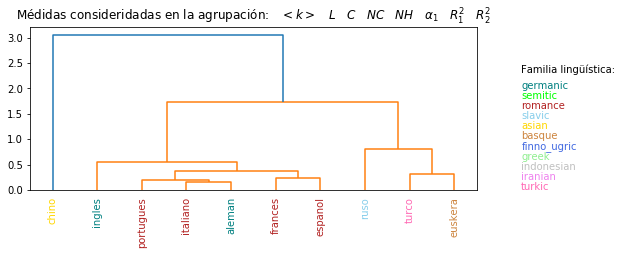

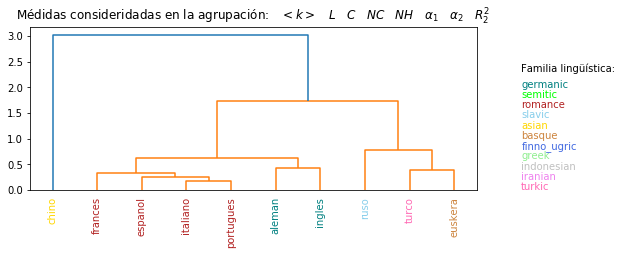

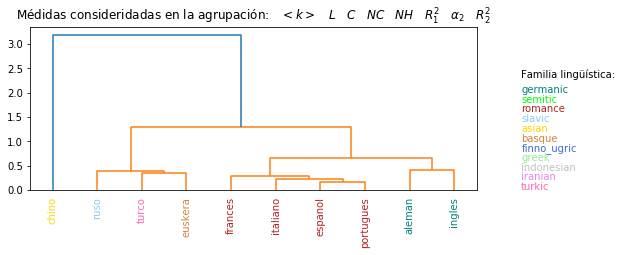

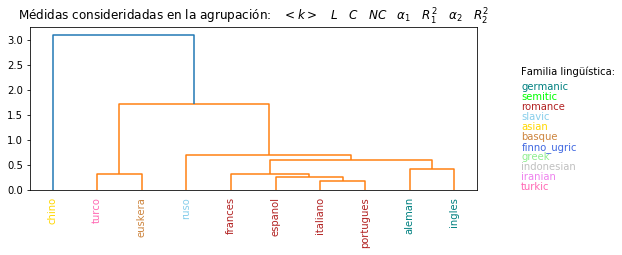

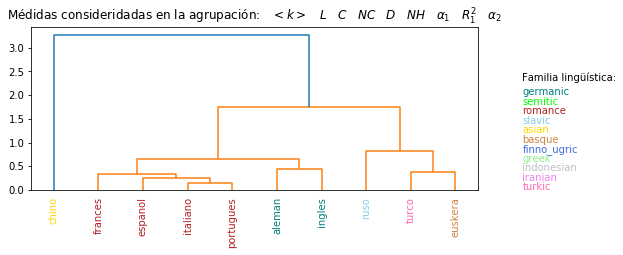

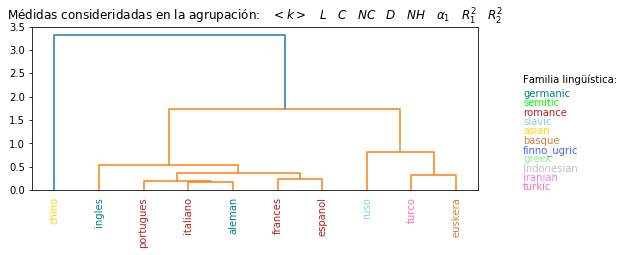

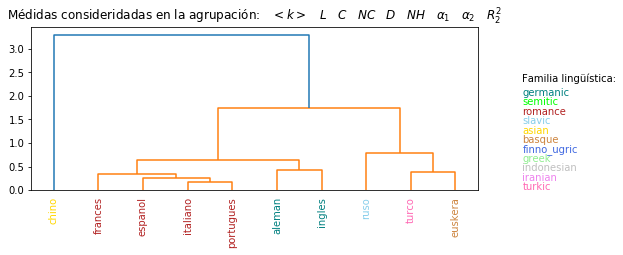

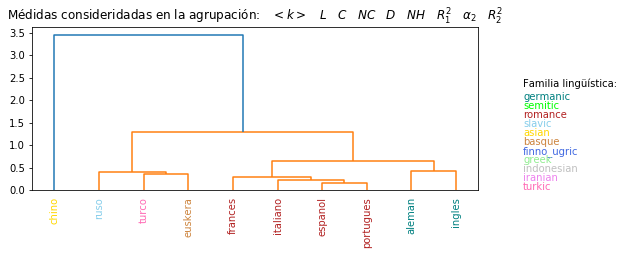

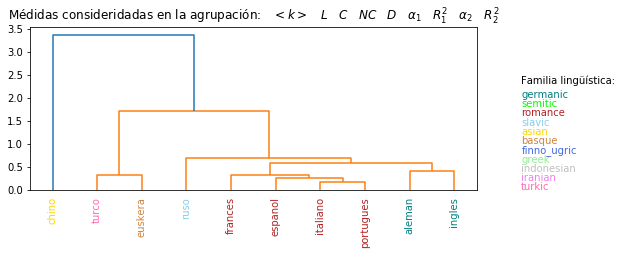

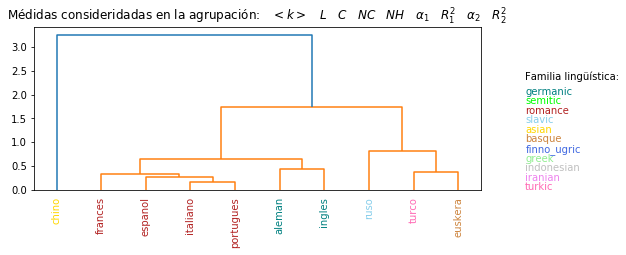

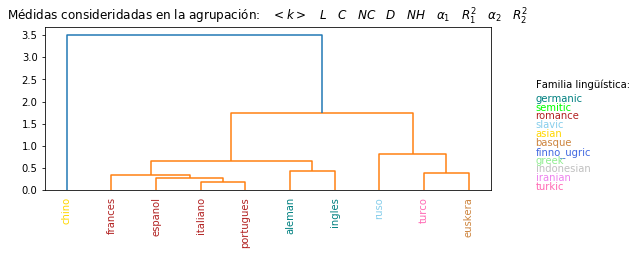

In [19]:
# se exploraron las 64 posibles combinaciones de los parametros base 
# (que se incluyen siempre) con los parámetros no base
params_base = ['$<k>$','$L$','$C$','$NC$']
params_no_base = ['$D$','$NH$',r'$\alpha_1$','$R^2_1$',r'$\alpha_2$','$R^2_2$']

from itertools import combinations
combis = sum([list(map(list, combinations(params_no_base, i))) for i in range(len(params_no_base)+ 1)], [])


## se clasifican los idiomas por familias lingüísticas 
germanic = 'teal'
semitic = 'lime'
romance = 'firebrick'
slavic ='skyblue'
asian = 'gold'
basque = 'peru'
finno_ugric = 'royalblue'
greek = 'lightgreen'
indonesian = 'silver'
iranian = 'violet'
turkic = 'hotpink'

familias = {
    'aleman': germanic,
    'arabe': semitic,
    'catalan': romance,
    'checo': slavic,
    'chino': asian,
    'coreano': asian,
    'danes': germanic,
    'espanol': romance,
    'euskera': basque,
    'finlandes': finno_ugric,
    'frances': romance,
    'griego': greek,
    'holandes': germanic,
    'hungaro': finno_ugric,
    'indonesio': indonesian,
    'ingles': germanic,
    'italiano': romance,
    'macedonio': slavic,
    'noruego': germanic,
    'persico': iranian,
    'polaco': slavic,
    'portugues': romance,
    'rumano': romance,
    'ruso': slavic,
    'serbio': slavic,
    'slovaco': slavic,
    'sloveno': slavic,
    'sueco': germanic,
    'tailandes': asian,
    'turco': turkic,
    'vietnamita': asian
}

## se aplica el análisis de agrupamiento (métdo de ward)
import scipy.cluster.hierarchy as shc

etiquetas = list(df_normalizado.idioma )

contador = 1

for combi in combis:
    medidas = params_base + combi

    data = df_normalizado.loc[:, medidas]
    contador += 1
    
    figura = plt.figure(figsize=(8,3))
    dend = shc.dendrogram(
        shc.linkage(data, method='ward'),
        labels=etiquetas,
        leaf_font_size = 10,
        leaf_rotation = 90
    )
    
    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(familias[lbl.get_text()])
    y_pos = 110
    plt.text(y_pos,2.3,'Familia lingüística:')
    plt.text(y_pos,2,'germanic',color=germanic)
    plt.text(y_pos,1.8,'semitic',color=semitic)
    plt.text(y_pos,1.6,'romance',color=romance)
    plt.text(y_pos,1.4,'slavic',color=slavic)
    plt.text(y_pos,1.2,'asian',color=asian)
    plt.text(y_pos,1,'basque',color=basque)
    plt.text(y_pos,0.8,'finno_ugric',color=finno_ugric)
    plt.text(y_pos,0.6,'greek',color=greek)
    plt.text(y_pos,0.4,'indonesian',color=indonesian)
    plt.text(y_pos,0.2,'iranian',color=iranian)
    plt.text(y_pos,0,'turkic',color=turkic)
    
    titulo = 'Médidas consideridadas en la agrupación:'
    for medida in medidas:
        titulo += '   ' + medida
        
    plt.title(titulo)
    plt.show()

### Algunas agrupaciones parecen sí seguir a las familias lingüísticas
- Las combinaciones que incluyen tanto $\alpha_1$ como $\alpha_2$ son las que mejor agrupan a las redes por sus familias lingüísticas. Agrupan a los a las lenguas germánicas y romances y a su vez agrupan a las indo-europeas (germánicas, romances y eslávicas (ruso))
- ¿Por qué aquí si salió y en la del manifiesto no?
- ¿El tamaño de la red afectará el análisis? (las redes que se generean con el manifiesto son más peques)

### 5. Fracaso 2

Este no agrupa tan chido como los de arriva, ya que el ruso lo mete no lo mete con los otros indoeuropeos

In [22]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

n_clusters=3
model = AgglomerativeClustering(n_clusters=n_clusters,linkage="average", affinity='Cosine')

model.fit(df.iloc[:,3:])

clusteres = []
for cluster in range(n_clusters):
    clus_list = []
    for i in range(len(df.iloc[:,3:])):
        if model.labels_[i]==cluster:
            clus_list.append(df.idioma[i])
    clusteres.append(clus_list)
    
for i in range(len(clusteres)):
    print('Cluster '+ str(i) + ' = ' + str(clusteres[i]) )

Cluster 0 = ['frances', 'italiano', 'aleman', 'espanol', 'portugues', 'ingles']
Cluster 1 = ['chino']
Cluster 2 = ['turco', 'euskera', 'ruso']


### 6. Texto aleatorio

Se genera un texto a partir una caminata aleatoria en una red dirigida del texto. El texto que se genera es sintacticamente correcto pero semanticamente no.

In [23]:
# se contruyen redes dirigidas y se genera un texto con una caminata aleatoria
DGs = {}

for idioma, enlaces in textos.items():
    DGs[idioma] = nx.DiGraph(enlaces) 

palabra = random.choice(list(DGs['espanol'].nodes()))
lista_caminata_aleatoria = [palabra]

for i in range(100):
    siguiente = random.choice(list(DGs['espanol'][palabra]))
    lista_caminata_aleatoria.append(siguiente)
    palabra = siguiente

cadena = ''
for palabra in lista_caminata_aleatoria:
    if palabra != '.':
        cadena = cadena + ' ' + palabra
    else:
        cadena = cadena + palabra

texto = ''

for oracion in cadena.split('.'):
    if len(oracion) >= 2:
        oracion = oracion[1].upper() + oracion[2:] + '.'
    texto = texto + ' ' + oracion

print(texto)

 Terencio lubianes. Pongamos entonces podrás ser exigente. Miguel ha ocurrido asaltar contla había salido la chacha margarita. Soy la antigua casa del santuario. Pregunta eres mi estómago engarruñado por mí señor cura quiere. Damiana llamó pedro decía adivino. Te irás conmigo hay pueblos llenando con las canelas. Sí yo saberlo me sentí encima. Abundio con todo tiene remedio. Ibas teñida de miel derramada ella apareció este pueblo que además y agarró la abuela lo hizo con paraguas venía. Una muchachita de mal hecho su propio pero la cuidamos. Rumores pies.
